In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelmax, argrelmin
from scipy.ndimage import gaussian_filter1d as gaussian
from itertools import combinations
import argparse
from argparse import Namespace
from pathlib import Path

In [9]:
def data_split(data, interval=9):
    return np.stack([data[i:i+interval] for i in range(len(data)-interval+1)])

def rsv_value(data, interval=9):
    split_data = data_split(data, interval=interval)
    M, m = split_data.max(axis=1), split_data.min(axis=1)
    return (split_data[:, -1] - m) / (M - m)

def kd_value(data, ratio=2):
    M, m = ratio/(ratio+1), 1/(ratio+1)
    ret = [0.5]
    for r in data:
        ret.append(ret[-1]*M + r*m)
    return np.array(ret)[1:]

def get_kdj(data, interval=9, ratio=2):
    rsv = rsv_value(data)
    k = kd_value(rsv)
    d = kd_value(k)
    j1 = 3*d - 2*k
    j2 = 3*k - 2*d
    return np.r_[np.zeros((8, 4)), np.c_[k, d, j1, j2]]

def get_scaled_kdj(data, scale=1, interval=9, ratio=2):
    n_d = [data[list(range(i, len(data), scale))] for i in range(scale)]
    per_kdj = [get_kdj(d) for d in n_d]
    kdjs = np.zeros((len(data), 4))
    for i, k in enumerate(per_kdj):
        kdjs[list(range(i, len(data), scale))] = k
    return kdjs

def less(a):
    return 1 if a[0] < a[1] else (0 if a[0] == a[1] else -1)

def get_labels(data, interval=8):
    return np.array([sum(map(less, combinations(data[i:i+interval+1], 2))) for i in range(len(data)-interval)]) / np.arange(interval+1).sum()

def argument_parsing():
    return Namespace(**{
        'kd_interval': 9,
        'kd_ratio': 2,
        'kd_blur_sigma': 1,
        'feature_length': 48,
        'label_blur_sigma': 10,
        'label_interval': 48,
        'data_dir': Path('./data')
    })

args = argument_parsing()
d = yf.download(tickers='BTC-USD', period='2y', interval = "1h")['Close']
blur_d = gaussian(d, sigma=args.kd_blur_sigma)

kdj_1h = get_kdj(blur_d, interval=args.kd_interval, ratio=args.kd_ratio)[24*(args.kd_interval-1):]
kdj_4h = get_scaled_kdj(blur_d, scale=4, interval=args.kd_interval, ratio=args.kd_ratio)[24*(args.kd_interval-1):]
kdj_24h = get_scaled_kdj(blur_d, scale=24, interval=args.kd_interval, ratio=args.kd_ratio)[24*(args.kd_interval-1):]
kdj_features = data_split(np.c_[kdj_1h, kdj_4h, kdj_24h], interval=args.feature_length)
truth_d = gaussian(d, sigma=args.label_blur_sigma)[24*(args.kd_interval-1)+args.feature_length-1:]
y = get_labels(truth_d, interval=args.label_interval)
x = kdj_features[:-args.label_interval]

[*********************100%***********************]  1 of 1 completed


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


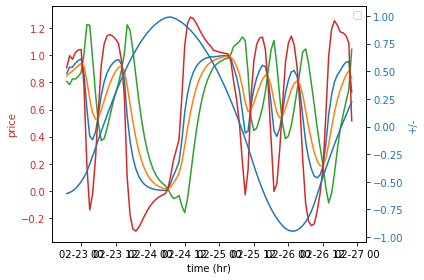

In [20]:
### Load Data ###
# with open('./data/2022_03_01_04.npz', 'rb') as f:
#     data = np.load(f, allow_pickle=True)
#     x, y, info = data['x'], data['y'], data['info'].item()

### Build Combine DataFrame ###
# k1_frame = pd.DataFrame(kdj_1h, columns=['K_1', 'D_1', 'J1_1', 'J2_1'], index=d[24*8:].index)
# k4_frame = pd.DataFrame(kdj_4h, columns=['K_4', 'D_4', 'J1_4', 'J2_4'], index=d[24*8:].index)
# k24_frame = pd.DataFrame(kdj_24h, columns=['K_24', 'D_24', 'J1_24', 'J2_24'], index=d[24*8:].index)
# res = pd.concat([d[24*8:], k1_frame, k4_frame, k24_frame], axis=1)

### Plotting ###
# plot_d = pd.DataFrame(kdj_1h[args.feature_length-1:-args.label_interval], index=d[24*(args.kd_interval-1)+args.feature_length-1:-args.label_interval].index)
# plot_y = pd.DataFrame(y, index=d[24*(args.kd_interval-1)+args.feature_length-1:-args.label_interval].index)
# fig, ax1 = plt.subplots()

# color = 'tab:red'
# ax1.set_xlabel('time (hr)')
# ax1.set_ylabel('price', color=color)
# ax1.plot(plot_d[-100:])
# ax1.tick_params(axis='y', labelcolor=color)
# ax1.legend()

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# color = 'tab:blue'
# ax2.set_ylabel('+/-', color=color)  # we already handled the x-label with ax1
# ax2.plot(plot_y[-100:], color=color)
# ax2.tick_params(axis='y', labelcolor=color)

# fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.show()